# Training in mini-batches: Stochastic gradient descent

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/msds621/blob/master/notebooks/deep-learning/7.SGD-minibatch-mnist.ipynb)

By [Terence Parr](https://explained.ai).

We've been using generic gradient descent to optimize our model so far.  Because we've been estimating gradients using the entire $\bf X$ matrix, we call this batch gradient descent. Each update of the model parameters occurs after considering all training instances (after each epoch). For batch gradient descent, there is one loss function computation per epoch.  If we process the training data in chunks rather than a single batch, we call it mini-batch gradient descent, or more commonly stochastic gradient descent (SGD). We update the model weights once per batch now instead of once per epoch. It is called stochastic because of the randomness and, hence, imprecision introduced by the computation of gradients on a subset of the training data. The randomness makes our weight "particle" bounce around and possibly jump out of local minima. After we've computed a gradient and updated weights for all mini-batches, we've finished an epoch. Next, we shuffle the batches, and iterate until convergence our we run out of AWS credits.

As before, we should run the network on a GPU.  The easiest way is just to click the icon above to run it at colab, and turn on the GPU runtime. (Go to "Change runtime type" under the runtime menu then select "GPU" under hardware accelerator; then select "Run all" under the runtime menu.) Or, you can still run it on your laptop/CPU; it'll just be slower.

## Why minibatch vs batch gradient descent?


Sometimes we have so much data that it will not fit on our GPU all at once; decent GPUs typically have around 12G of RAM.  For big problems, we need to break it up into batches. In general we want the biggest batch we can fit on the GPU to leverage more parallelism, but we often see a reduction in model generalization (higher validation loss) with bigger batches. That has been the conventional wisdom:

<a href="https://twitter.com/ylecun/status/989610208497360896"><img src="https://explained.ai/rnn/images/lecunn-batch-size.png" width="250"></a>
 
This is still an open question, but there are those that claim with a carefully constructed dynamic learning rate and batch size, the so-called generalization gap can be eliminated. Here are a few things to look at on both sides of the argument:

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)
* [A Closer Look at the Generalization Gap in Large Batch Training of Neural Networks](https://syncedreview.com/2020/09/13/a-closer-look-at-the-generalization-gap-in-large-batch-training-of-neural-networks/)
* [Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour](https://research.fb.com/wp-content/uploads/2017/06/imagenet1kin1h5.pdf)

Note: Even if we know for sure that a lower batch size on a particular problem leads to better generality, for practical efficiency reasons, we might need to increase the batch size so that the training terminates in our lifetime.

Let's redo the MNIST example using the GPU but with SGD.

## Support code

In [34]:
import os
import sys
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

As before, let's load a sample of 10,000 MNIST images:

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

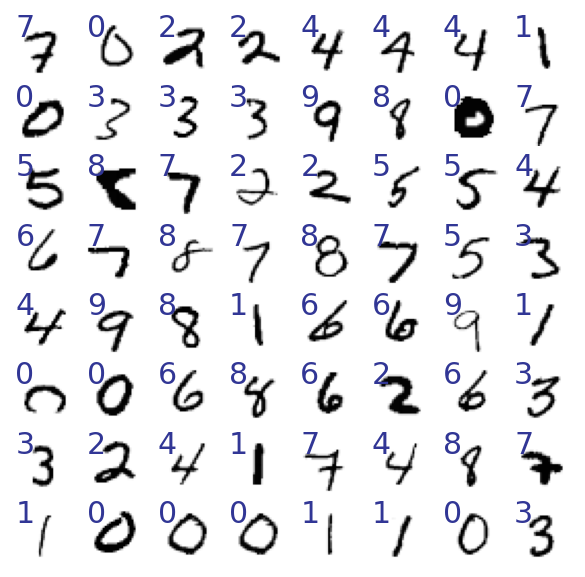

In [6]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

As before, create tensors from the $\bf X$ and $\bf y$ data, move the data to the GPU, and split out a validation set:

In [7]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training loop

Now let's create a training function that uses stochastic gradient descent, which means updating the model parameters by computing the loss for a subset (a minibatch) of the overall training data. Previously we computed the predictions and loss with:

```python
y_pred = model(X_train)
loss = F.cross_entropy(y_pred, y)
```

But, now we need to break up `X_train` into chunks and iterate across the chunks. So that simple prediction and loss computation becomes another loop:

<img src="images/minibatch-train.png" width="800">

We also must shuffle the data set at the start of every epoch to avoid getting the training loop into a rut.  To get the best stochastic nature, thus improving generality, we should not use the same sequence of mini-batches.

In [40]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

## Train with batch gradient descent

Let's get started by defining the same model we've been using:

In [9]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

To verify that our stochastic gradient descent training algorithm is correct, let's perform batch gradient descent by setting the mini-batch size to the length of the training set. 

In [10]:
%%time
# On a CPU, this takes about 40 seconds but only 4 seconds on a GPU at colab.
# It only took 20 seconds to do the batch version of this in the previous notebook
# because we are doing more work in this version of the training loop.
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=1000,
                     batch_size=len(X_train) # perform batch not mini-batch gradient descent
                  )

Epoch    0 cross entropy loss  2.3026   test loss  2.2004
Epoch  100 cross entropy loss  1.4915   test loss  1.5132
Epoch  200 cross entropy loss  1.4858   test loss  1.5088
Epoch  300 cross entropy loss  1.4845   test loss  1.5082
Epoch  400 cross entropy loss  1.4828   test loss  1.5063
Epoch  500 cross entropy loss  1.4810   test loss  1.5055
Epoch  600 cross entropy loss  1.4800   test loss  1.5058
Epoch  700 cross entropy loss  1.4797   test loss  1.5043
Epoch  800 cross entropy loss  1.4791   test loss  1.5049
Epoch  900 cross entropy loss  1.4789   test loss  1.5044
Epoch 1000 cross entropy loss  1.4789   test loss  1.5045
BEST test cross entropy loss 1.504 at epoch 702
CPU times: user 55.8 s, sys: 3.61 s, total: 59.4 s
Wall time: 42.9 s


In [11]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.982


In [12]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.956


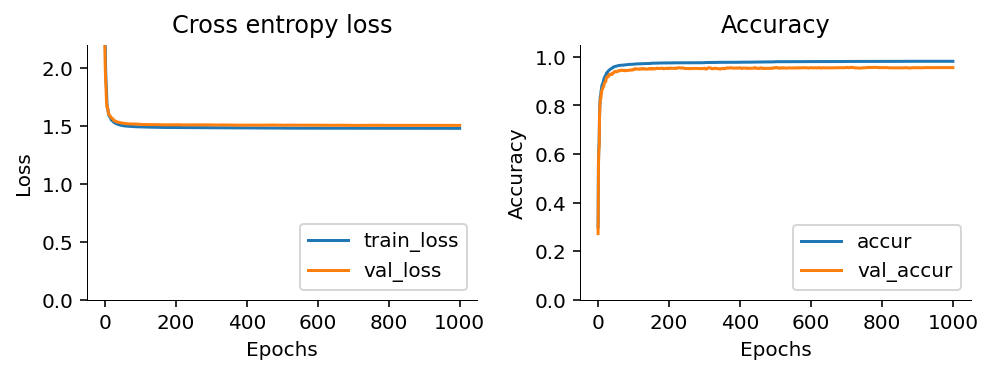

In [13]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

## Try mini-batch

Ok the batch results look like what we saw before so let's assume our algorithm works correctly. Now, let's try a stochastic run using mini-batches.  One of the first things to notice is that, given the stochastic nature due to the imprecise gradient estimates, we need to decrease the learning rate. Otherwise, we'll jump too far away along a path different from the true gradient. Let's create the same model except use a batch size of 8 images rather than `len(X_train)` to compute gradients via the loss function.  Also, we don't need to train very long because we know that a decent model appears almost immediately.

In [14]:
%%time
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

# Mini-batching dramatically slows down the process compared to batch gradient descent
# because the GPU can only operate on small chunks of data at once, rather than one
# big matrix during batch gradient descent.
# This takes about 51s on my CPU.  Oddly enough, it takes longer on the colab
# GPU, 1min 10s, likely because we are not getting that much parallelism and my CPU
# is faster for sequential operations.
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .001, # small learning rate due to imprecise gradients
                     nepochs=50,           # very few iterations for speed
                     batch_size=8          # very small batch size
                  )

Epoch    0 cross entropy loss  1.4916   test loss  1.5810
Epoch    5 cross entropy loss  1.5925   test loss  1.5238
Epoch   10 cross entropy loss  1.4613   test loss  1.5136
Epoch   15 cross entropy loss  1.4653   test loss  1.5041
Epoch   20 cross entropy loss  1.4613   test loss  1.5026
Epoch   25 cross entropy loss  1.4612   test loss  1.5046
Epoch   30 cross entropy loss  1.4612   test loss  1.5000
Epoch   35 cross entropy loss  1.5851   test loss  1.5008
Epoch   40 cross entropy loss  1.4617   test loss  1.5025
Epoch   45 cross entropy loss  1.4612   test loss  1.5015
Epoch   50 cross entropy loss  1.4612   test loss  1.5004
BEST test cross entropy loss 1.499 at epoch 36
CPU times: user 39.9 s, sys: 4.74 s, total: 44.6 s
Wall time: 39.4 s


In [15]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.986


In [16]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.961


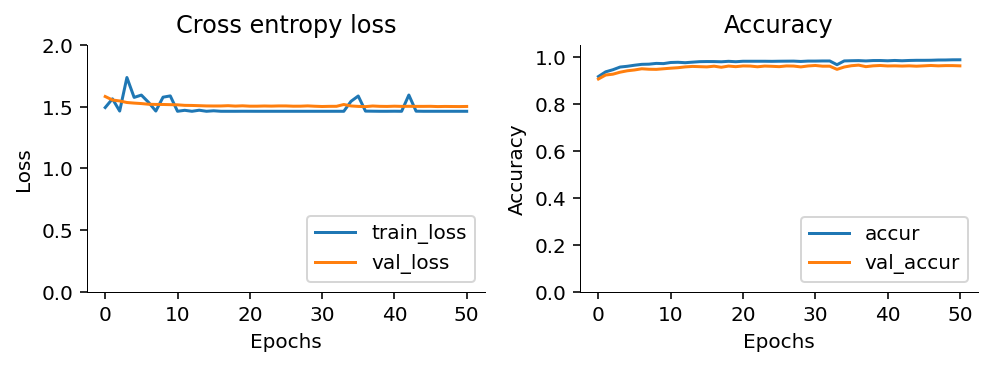

In [17]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

In the end mini-batch gradient descent does not dramatically change our generality here. But, remember, we are very close to 100% accurate already, so we must fight very hard for improvements at this point. (Mini-batch is also wildly less efficient.)   To truly get a better classifier, we need to use  convolutional neural networks.

#### Exercise

Compare and explain the difference in the training loss history plots for mini-batch and batch gradient descent.

<details>
<summary>Solution</summary>
    The loss history for mini-batch gradient descent is going to be much noisier because our estimates of the gradient are imprecise. That means we will sometimes bounce in the wrong direction when trying to reach the minimum loss location. The validation loss is smooth because we are computing it on the entire data set, not batches.  We are only mini-batching the training data.
</details>

## Try a variety of mini batch sizes

In [78]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
#             clip = 5
#             nn.utils.clip_grad_norm_(model.parameters(), clip)
#             print("foo")
#             for index, param in enumerate(model.parameters()):
#                 print( f"{torch.max(torch.abs(param.grad)):.8f}" )
                
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

Batch size 4096
Epoch    0 cross entropy loss  2.0636   test loss  2.1287
Epoch    5 cross entropy loss  2.2837   test loss  2.2796
Epoch   10 cross entropy loss  2.2859   test loss  2.2691
Epoch   15 cross entropy loss  2.2815   test loss  2.2706
Epoch   20 cross entropy loss  2.2841   test loss  2.2743
Epoch   25 cross entropy loss  2.2734   test loss  2.2706
Epoch   30 cross entropy loss  2.2749   test loss  2.2731
Epoch   35 cross entropy loss  2.3643   test loss  2.3602
Epoch   40 cross entropy loss  2.3659   test loss  2.3602
Epoch   45 cross entropy loss  2.3654   test loss  2.3602
Epoch   50 cross entropy loss  2.3636   test loss  2.3602
BEST test cross entropy loss 2.129 at epoch 0


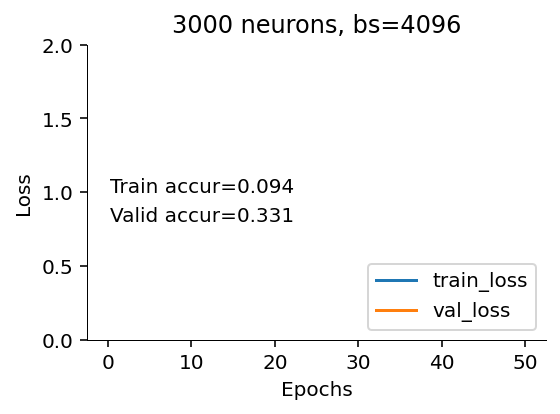

In [79]:
n_neurons = 3000
sizes = [8,      64,  128,  256, 1024, 2048]
rates = [.001, .001, .001, .005, .03, .04]
sizes = [4096]
rates = [.05]
fig, axes = plt.subplots(len(sizes), 1, figsize=(4,len(sizes)*3))
if not isinstance(axes,np.ndarray):
    axes = [axes]
ncols = X.shape[1]
for r,bs,ax in zip(rates,sizes,axes):
    print(f"Batch size {bs}")
    model = nn.Sequential(
        nn.Linear(784, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 10),  # 10 output classes (0-9)
        nn.Softmax(dim=1)
    )
    model = model.to(device)
    history,best_model = sgdtrain(model, X_train, y_train, X_test, y_test,
                                 learning_rate = r, nepochs=50, # few epochs for speed
                                 batch_size=bs
                                )
    
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        train_accur = ncorrect.float() / len(y_train)

    y_test_pred = best_model(X_test)
    y_test_pred = torch.argmax(y_test_pred, axis=1)
    ncorrect = torch.sum(y_test_pred==y_test)
    test_accur = ncorrect.float() / len(y_test)
    ax.set_title(f"{n_neurons} neurons, bs={bs}")
    ax.text(.25, 1.0, f"Train accur={train_accur:.3f}")
    ax.text(.25, 0.8, f"Valid accur={test_accur:.3f}")
    plot_loss(history, ax=ax, maxy=2)

plt.tight_layout()
plt.show()

At least for this model, data set, and hyper parameters, increasing the batch size reduces generality.  The validation accuracy gradually decreases as we increase batch size.